In [44]:
import sys
print(sys.executable)

c:\Users\compu\AppData\Local\Programs\Python\Python311\python.exe


In [45]:
#carico il dataset pulito
import pandas as pd
df = pd.read_csv('ai_vs_human_dataset_cleaned.csv')

#visualizzo le prime righe del dataset
df.head()

,label,topic,text,length_chars,length_words,quality_score,sentiment,plagiarism_score,cleaned_text
0,human,food,"As someone who follows food, I believe privacy...",126,22,2.37,0.44,0.045,someone follows food believe privacy concerns ...
1,ai,travel,Analysis indicates that travel is associated w...,141,19,3.44,0.60,0.007,analysis indicates travel associated privacy c...
2,human,education,I recently experienced education in my day-to-...,112,17,3.16,-0.43,0.163,recently experienced education daytoday life f...
3,ai,sports,Analysis indicates that sports is associated w...,101,14,3.32,0.44,0.122,analysis indicates sports associated costs var...
4,human,finance,"In my experience, finance often leads to users...",78,14,3.52,-0.31,0.105,experience finance often leads users report mi...


### 1. Preparazione dei Dati e Import delle Librerie


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Definiamo le features (X) e il target (y)
X = df['text']
y = df['label']

### 2. Vettorizzazione del Testo


In [47]:
import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer

# Modello SBERT
embedder = SentenceTransformer("all-MiniLM-L6-v2")


### Creazione degli embeddings

In [48]:
texts = df['cleaned_text'].tolist()

X_embeddings = embedder.encode(
    texts,
    batch_size=32,
    show_progress_bar=True
)

X_embeddings.shape

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches: 100%|██████████| 16/16 [00:02<00:00,  7.85it/s]


(500, 384)

In [49]:
""" # Inizializziamo il vettorizzatore TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Trasformiamo i dati di testo in una matrice TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X) """

" # Inizializziamo il vettorizzatore TF-IDF\ntfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)\n\n# Trasformiamo i dati di testo in una matrice TF-IDF\nX_tfidf = tfidf_vectorizer.fit_transform(X) "

### 3. Feature Engineering: Combiniamo le Feature

In [50]:
""" #scipy serve 
from scipy.sparse import hstack
import numpy as np

# Selezioniamo le feature numeriche che vogliamo includere
numerical_features = df[['quality_score', 'sentiment', 'length_chars', 'length_words', 'plagiarism_score']]

# Combiniamo la matrice TF-IDF con le feature numeriche
# È importante convertire le feature numeriche in un formato compatibile (es. CSR matrix) prima di unirle
X_combined = hstack([X_tfidf, np.array(numerical_features)]) """

" #scipy serve \nfrom scipy.sparse import hstack\nimport numpy as np\n\n# Selezioniamo le feature numeriche che vogliamo includere\nnumerical_features = df[['quality_score', 'sentiment', 'length_chars', 'length_words', 'plagiarism_score']]\n\n# Combiniamo la matrice TF-IDF con le feature numeriche\n# È importante convertire le feature numeriche in un formato compatibile (es. CSR matrix) prima di unirle\nX_combined = hstack([X_tfidf, np.array(numerical_features)]) "

### 4. Divisione del Dataset in Training e Test Set

In [51]:
from sklearn.model_selection import train_test_split

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)

### 5. Addestramento del Modello di Regressione Logistica

In [52]:
# Inizializziamo il modello di Regressione Logistica

model_sbert = LogisticRegression(max_iter=1000, n_jobs=-1)

model_sbert.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 6. Valutazione del Modello

Accuratezza del modello: 1.0000


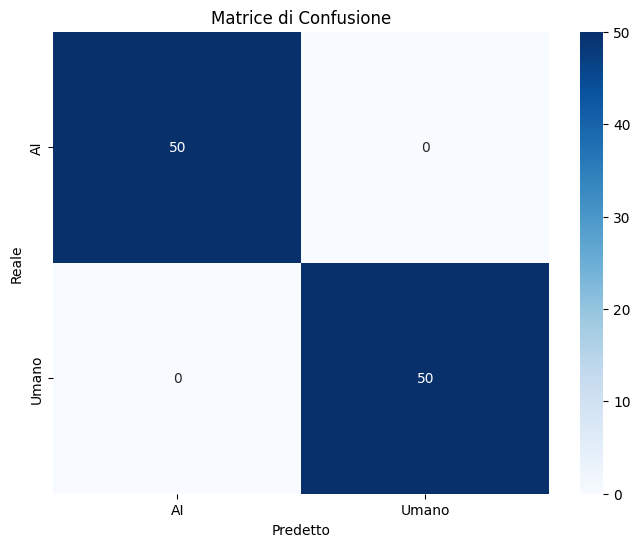


Classification Report:
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00        50
       Umano       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [53]:
# Facciamo predizioni sul test set
y_pred = model_sbert.predict(X_test)

# Calcoliamo l'accuratezza
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza del modello: {accuracy:.4f}")

# Generiamo la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizziamo la matrice di confusione con una heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Umano'], yticklabels=['AI', 'Umano'])
plt.title('Matrice di Confusione')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

# Stampiamo il classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['AI', 'Umano']))

### 7. Addestramento e Valutazione di un Random Forest Classifier

Ora proviamo un modello più complesso, il **Random Forest**, per vedere se possiamo ottenere performance migliori. Essendo un modello *ensemble*, combina le previsioni di molti alberi decisionali per produrre un risultato più accurato e robusto.

Il processo è identico a prima: addestriamo il modello sul training set e lo valutiamo sul test set.

Addestramento del Random Forest in corso...
Addestramento completato.

Accuratezza del Random Forest: 0.8900


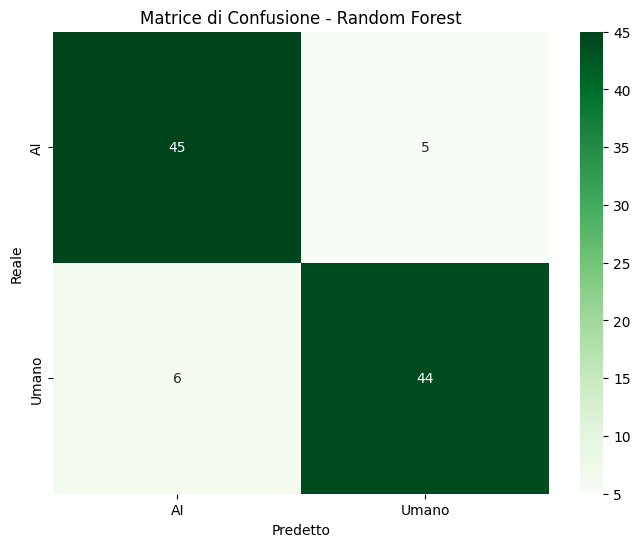


Classification Report - Random Forest:
              precision    recall  f1-score   support

          AI       0.88      0.90      0.89        50
       Umano       0.90      0.88      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [54]:
from sklearn.ensemble import RandomForestClassifier

# Inizializziamo il modello Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Addestriamo il modello sul training set
print("Addestramento del Random Forest in corso...")
rf_model.fit(X_train, y_train)
print("Addestramento completato.")

# Facciamo predizioni sul test set
y_pred_rf = rf_model.predict(X_test)

# Calcoliamo l'accuratezza
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuratezza del Random Forest: {accuracy_rf:.4f}")

# Generiamo la matrice di confusione
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizziamo la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['AI', 'Umano'], yticklabels=['AI', 'Umano'])
plt.title('Matrice di Confusione - Random Forest')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

# Stampiamo il classification report
print("\nClassification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['AI', 'Umano']))

In [55]:
from sklearn.metrics import f1_score

# Calculate F1-scores for both models
lr_f1 = f1_score(y_test, y_pred, pos_label='human')
rf_f1 = f1_score(y_test, y_pred_rf, pos_label='human')

results = pd.DataFrame({
    "Model": [
        "Logistic Regression + SBERT",
        "Random Forest + SBERT"
    ],
    "Accuracy": [
        accuracy,
        accuracy_rf
    ],
    "F1-score": [
        lr_f1,
        rf_f1
    ]
})

results


,Model,Accuracy,F1-score
0,Logistic Regression + SBERT,1.00,1.000000
1,Random Forest + SBERT,0.89,0.888889


In [56]:
import re

test_text = """
This article explores the implications of advanced artificial intelligence 
systems on modern digital communication frameworks.
"""

# Clean the test text (same preprocessing as the training data)
test_text_cleaned = test_text.lower()
test_text_cleaned = re.sub(r'[^a-z\s]', '', test_text_cleaned)
test_text_cleaned = re.sub(r'\s+', ' ', test_text_cleaned).strip()

test_embedding = embedder.encode([test_text_cleaned])
test_embedding.shape


(1, 384)

In [57]:
prediction = rf_model.predict(test_embedding)
prediction_proba = rf_model.predict_proba(test_embedding)

print("Predizione:", prediction[0])
print("Probabilità:", prediction_proba)




Predizione: human
Probabilità: [[0.38 0.62]]


In [58]:
# The prediction is already a string ('human' or 'ai'), so we can use it directly
print("Il testo è classificato come:", prediction[0].capitalize())

Il testo è classificato come: Human
